# Análise de Dados Soccer2D

## Introdução

Esta oficina proporcionará uma introdução prática e direta à análise de dados no contexto de futebol de robôs, utilizando dados coletados de partidas da RoboCup Soccer Simulation 2D, que é uma competição em que dois times de 11 robôs autônomos simulados joguem uma partida de futebol contra outros times.

Caso deseje rodar este notebook no ambiente do Colab, basta fazer o upload de todo o diretório e descomentar a célula abaixo, **ajustando o path com a localização do diretório no Drive ;)**

In [1]:
# # permite o acesso aos dados
# from google.colab import drive
# drive.mount('/content/drive/')

## Objetivos

1. Processar dados de uma partida;
2. Extrair insights úteis a partir de dados coletados;
3. Identificar as estratégias utilizadas pelas melhores equipes da competição;

Antes de iniciarmos as análises, nós precisamos que algumas bibliotecas já estejam disponíveis. São elas:

- [Numpy](http://www.numpy.org/) para todas as operações matriciais;
- [Matplotlib](https://matplotlib.org/) para a plotagem dos gráficos;
- [Pandas](https://pandas.pydata.org/docs/index.html) que contém funções e ferramentas de manipulação e visualização de dados.
- [Seaborn](https://seaborn.pydata.org/index.html) para visualização dos dados;
- [Scikit-learn](https://scikit-learn.org/stable/index.html) para utilização de algoritmos de machine learning e outras funções úteis.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

## 1. Exploração dos dados

Nesta etapa, carregaremos o dataset e, em seguida, detalharemos as informações que ele possui.

In [3]:
# ajuste o path para a localização do arquivo csv
df = pd.read_csv('data/Oxsy_1-vs-YuShan2023_3.csv')

In [4]:
# visualizando os dados
df.head()

,show_time,playmode,team_name_l,team_name_r,team_score_l,team_score_r,team_pen_score_l,team_pen_score_r,team_pen_miss_l,team_pen_miss_r,...,player_r11_counting_dash,player_r11_counting_turn,player_r11_counting_catch,player_r11_counting_move,player_r11_counting_turn_neck,player_r11_counting_change_view,player_r11_counting_say,player_r11_counting_tackle,player_r11_counting_point_to,player_r11_counting_attention_to
0,1,kick_off_l,Oxsy,YuShan2023,0,0,0,0,0,0,...,1,98,0,1,100,1,0,0,0,1
1,2,kick_off_l,Oxsy,YuShan2023,0,0,0,0,0,0,...,2,98,0,1,101,2,0,0,0,2
2,3,kick_off_l,Oxsy,YuShan2023,0,0,0,0,0,0,...,2,99,0,1,102,2,0,0,0,2
3,4,kick_off_l,Oxsy,YuShan2023,0,0,0,0,0,0,...,2,100,0,1,103,2,0,0,0,2
4,5,kick_off_l,Oxsy,YuShan2023,0,0,0,0,0,0,...,2,101,0,1,104,2,0,0,0,3


In [5]:
# visualizando todas as colunas e uma lista
df.columns.to_list()

['show_time',
 'playmode',
 'team_name_l',
 'team_name_r',
 'team_score_l',
 'team_score_r',
 'team_pen_score_l',
 'team_pen_score_r',
 'team_pen_miss_l',
 'team_pen_miss_r',
 'ball_x',
 'ball_y',
 'ball_vx',
 'ball_vy',
 'player_l1_side',
 'player_l1_unum',
 'player_l1_type',
 'player_l1_state',
 'player_l1_x',
 'player_l1_y',
 'player_l1_vx',
 'player_l1_vy',
 'player_l1_body',
 'player_l1_neck',
 'player_l1_point_to_x',
 'player_l1_point_to_y',
 'player_l1_view_quality',
 'player_l1_view_width',
 'player_l1_attribute_stamina',
 'player_l1_attribute_effort',
 'player_l1_attribute_recovery',
 'player_l1_attribute_stamina_capacity',
 'player_l1_focus_side',
 'player_l1_counting_kick',
 'player_l1_counting_dash',
 'player_l1_counting_turn',
 'player_l1_counting_catch',
 'player_l1_counting_move',
 'player_l1_counting_turn_neck',
 'player_l1_counting_change_view',
 'player_l1_counting_say',
 'player_l1_counting_tackle',
 'player_l1_counting_point_to',
 'player_l1_counting_attention_to',


As colunas do dataset contém informações acerca da partida e de cada um dos jogadores de cada time. Algumas das colunas que utilizaremos nesta análise podem ser descritas da seguinte forma:

partida:
- show_time: ciclo do servidor (~ 0.1 segundo)
- playmode: estado atual do jogo (escanteio, pênalti, falta, etc)
- team_name_[LADO]: nome do time que está em cada lado
- team_score_[LADO]: gols de cada time
- team_pen_score_[LADO]: gols de pênalti
- team_pen_miss_[LADO]: gols de pênalti perdidos
- ball_[COORD]: coordenada x ou y da bola
- ball_v[COORD]: velocidade da bola no eixo x ou y

jogadores:
- player_[LADO][NUM_JOG]_type: id do tipo de cada jogador (meio-campista, defensor, goleiro, etc.)
- player_[LADO][NUM_JOG][COORD]: coordenada x ou y do jogador
- player_[LADO][NUM_JOG]_v[COORD]: velocidade do jogador
- player_[LADO][NUM_JOG]_body: angulação do corpo do jogador, variando no intervalo de (-180, 180) graus
- player_[LADO][NUM_JOG]_neck: angulação do pescoço do jogador, variando no intervalo de (-90, 90) graus

Além dos dados descritos acima, há informações sobre atributos dos jogadores e contagem do número de ações de cada jogador, como faltas, chutes, defesas, etc.

A coluna `playmode` descreve modos do jogo que podem ocorrer durante a partida. Cada modo corresponde à um evento, semelhante ao futebol da vida real.

In [7]:
df['playmode'].unique()

array(['kick_off_l', 'play_on', 'kick_in_r', 'goal_r', 'foul_charge_l',
       'free_kick_r', 'kick_in_l', 'goal_l', 'kick_off_r', 'offside_r',
       'free_kick_l', 'foul_charge_r', 'goal_kick_r', 'goal_kick_l',
       'corner_kick_l', 'time_over'], dtype=object)

Segue a descrição de cada modo de jogo:

- **kick_off_[LADO]**: Início da partida com o time à esquerda ou direita dando o pontapé inicial.
- **play_on**: O jogo está em andamento normalmente, sem interrupções.
- **kick_in_[LADO]**: O time à direita ou esquerda executa um arremesso lateral.
- **goal_[LADO]**: Gol marcado pelo time à direita ou esquerda.
- **foul_charge_[LADO]**: Falta cometida pelo time à esquerda ou direita por carga irregular.
- **free_kick_[LADO]**: Cobrança de falta para o time à direita ou esquerda.
- **kick_off_[LADO]**: Início da partida ou reinício com o time à direita ou esquerda dando o pontapé inicial.
- **offside_[LADO]**: Impedimento do time à direita ou esquerda.
- **goal_kick_[LADO]**: Tiro de meta cobrado pelo time à direita ou esquerda.
- **corner_kick_[LADO]**: Cobrança de escanteio pelo time à esquerda ou direita.
- **time_over**: O tempo regulamentar do jogo terminou.

## 3. Processando os dados

### 3.1 Funções e classes auxiliares

Antes de começarmos a análise, vale definir algumas funções e classes que podem ser úteis durante o processo.

Para simplificar, optamos por criar um arquivo chamado `geom_2d` que contém implementação de abstrações geométricas, como o ponto e o círculo, além de funções como o cálculo de distância entre dois pontos.

Também criamos funções auxiliares no arquivo `helpers.py` que irão extrair e processar dados úteis a partir dos dados coletados, como estimar a posse de bola a partir da posição dos jogadores.

No entanto, recomendamos fortemente que você abra e entenda o código desses arquivos para ampliar o seu entendimento da análise como um todo. Todos os códigos disponibilizados foram implementados e comentados para que o seu entendimento seja facilitado.

In [8]:
from geom_2d import Point, Circle, distance
from helpers import *

Para reunir todos os dados processados que obteremos nesta etapa, criaremos um novo dataset.

In [9]:
game_stats = pd.DataFrame()

#### Posse de bola

Para calcular a posse de bola, basta calcular a porcentagem do tempo total em que um determinado time esteve com a bola.

$$P_{t} = \frac{T_{t}}{T_{Total}} * 100$$

Consideraremos que o time mais próximo da bola terá o domínio.

In [10]:
# colunas referentes às coordenadas de cada jogador
players_left = []
players_right = []
for i in range(1, 12):
    players_left.append((f'player_l{i}_x', f'player_l{i}_y'))
    players_right.append((f'player_r{i}_x', f'player_r{i}_y'))
players = [players_left, players_right]

Para o cálculo do tempo em que cada time esteve com a posse da bola, iremos iterar por cada ciclo do servidor, contando os ciclos em que cada time esteve sob o domínio da bola. 

Utilizaremos a função `possession_at` para determinar de quem é a posse a cada ciclo. A implementação desta função se encontra no arquivo `helpers.py`. 

In [11]:
# momentos em que o jogo não estava parado
filtered_game = df[df['playmode'] == 'play_on']

# inicializa os contadores de tempo
time_left = time_right = 0

# inicializa uma lista para armazenar a posse a cada instante
possession_data = []

for cycle, row in filtered_game.iterrows():
  # função auxiliar possession_at() para determinar a posse
  possession_side = possession_at(cycle, filtered_game, players)

  if possession_side == 'left':
    time_left += 1
  else:
    time_right += 1

  # cálculo das posses
  total_time = time_left + time_right
  possession_left = time_left/ total_time
  possession_right = time_right/ total_time

  # armazena a posse a cada instante
  possession_data.append({'cycle': cycle, 'possession_l': possession_left, 'possession_r': possession_right})

# converte a lista para um DataFrame e adiciona ao game_stats
possession_df = pd.DataFrame(possession_data)
game_stats = pd.concat([game_stats, possession_df], axis=1)

team_name_left = df['team_name_l'][0]
team_name_right = df['team_name_r'][0]

# posse no formato tabelado
possession_summary = pd.DataFrame({
  'Time': [team_name_left, team_name_right],
  'Posse (%)': [possession_left * 100, possession_right * 100]
})

print("Posse de bola")
print("==========================")
print(possession_summary.to_string(index=False))
print("==========================")

Posse de bola
      Time  Posse (%)
      Oxsy   37.50306
YuShan2023   62.49694


Podemos gerar visualizações da posse de bola para extrair insights úteis

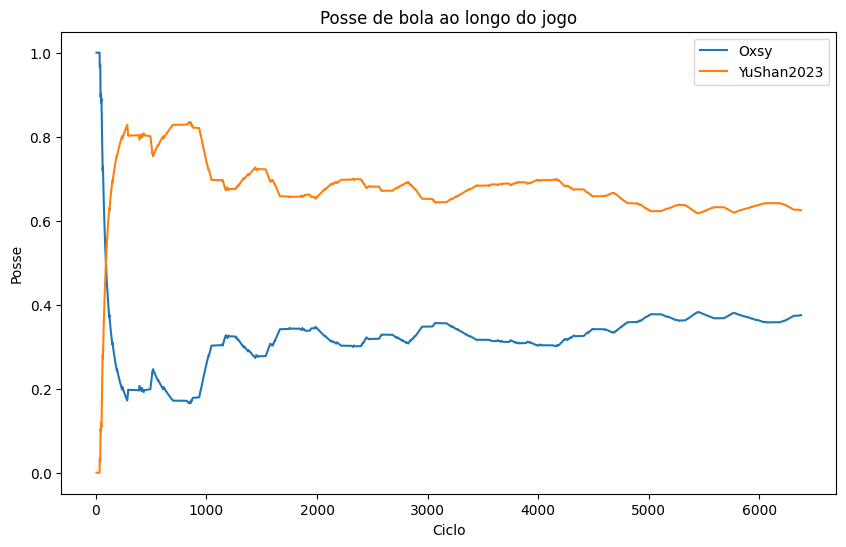

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(game_stats['cycle'], game_stats['possession_l'], label=team_name_left)
plt.plot(game_stats['cycle'], game_stats['possession_r'], label=team_name_right)
plt.xlabel('Ciclo')
plt.ylabel('Posse')
plt.title('Posse de bola ao longo do jogo')
plt.legend(loc='upper right')
plt.show()

A ocorrência de gols alteraram a posse de bola de cada time?

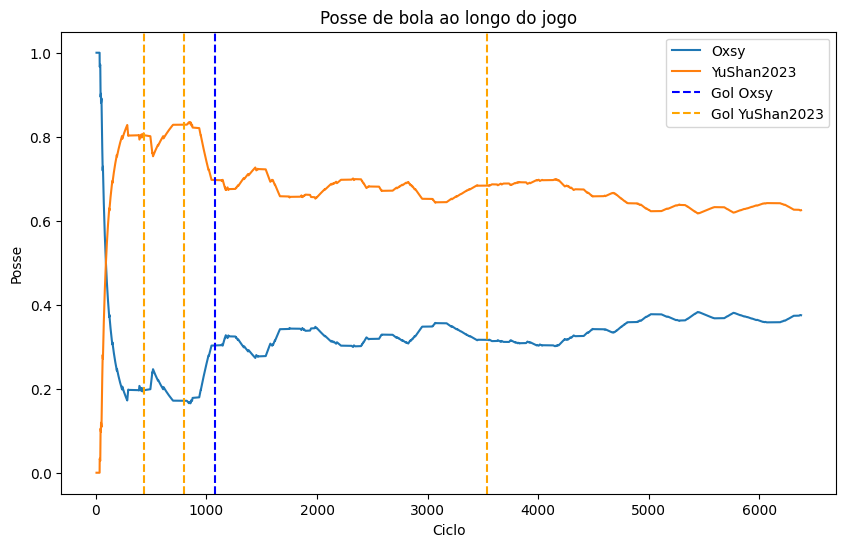

In [37]:
# Ciclos em que um gol ocorreu
goal_cycles_l = df[df['playmode'] == 'goal_l']['show_time'].unique()
goal_cycles_r = df[df['playmode'] == 'goal_r']['show_time'].unique()

plt.figure(figsize=(10, 6))
plt.plot(game_stats['cycle'], game_stats['possession_l'], label=team_name_left)
plt.plot(game_stats['cycle'], game_stats['possession_r'], label=team_name_right)

# indica o ciclo em que um dos dois times marcaram gols
for cycle in goal_cycles_l:
    plt.axvline(x=cycle, color='blue', linestyle='--', label=f'Gol {team_name_left}')

for cycle in goal_cycles_r:
    plt.axvline(x=cycle, color='orange', linestyle='--', label=f'Gol {team_name_right}')

# remove legendas duplicadas
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel('Ciclo')
plt.ylabel('Posse')
plt.title('Posse de bola ao longo do jogo')
plt.show()

#### Passes

Para contabilizar os passes de cada time, precisaremos iterar por cada ciclo do servidor, monitorando os passes e mudanças de posse de bola, enquanto rastreamos o número de passes corretos, errados e interceptados para ambos os times.

**Para cada ciclo do jogo**:
- Verifica-se se um jogador do time direito ou esquerdo fez um passe.
- Se um passe está em andamento, determinamos a posse da bola e atualizamos os contadores de passes corretos, errados ou interceptados com base na continuidade ou interrupção da posse.
- Para passes interceptados, verifica-se se houve interrupções no jogo (`kick_off` ou `foul_charge`) nos ciclos seguintes, ajustando o contador se necessário.

O objetivo final é contabilizar a eficácia dos passes e a frequência de interceptações durante o jogo.

In [38]:
# Inicializa contadores para passes corretos, errados e interceptados para ambos os times
correct_passes_l = 0
wrong_passes_l = 0
intercepted_passes_l = 0

correct_passes_r = 0
wrong_passes_r = 0
intercepted_passes_r = 0

# Inicializa flags para indicar se um passe está em andamento
pass_r = False
pass_l = False

# Inicializa posições dos jogadores
player_right_position = Point()
player_left_position = Point()

# Itera sobre cada ciclo de jogo
for current_cycle, row in df.iterrows():
    # Verifica se o time direito fez um passe
    if not pass_r:
        pass_r, player_who_kicked = kick(current_cycle, 'r', df, True) # Verifica se ocorreu um passe
    else:
        pass_l = False

        # Verifica se a bola saiu pela lateral do time direito
        if df['playmode'][current_cycle] == 'kick_in_l':
            pass_r = False
            wrong_passes_r += 1
            continue

        # Define a posse de bola
        possession, player_who_possesses = define_player_possession(current_cycle, player_left_position, 
                                                                    player_right_position, players, df, True)

        # Se a posse de bola continua com o time direito
        if possession == 'right':
            pass_r = False
            if player_who_kicked != player_who_possesses: # Conta apenas se o passe foi para outro jogador
                correct_passes_r += 1

        # Se a posse de bola foi interceptada pelo time esquerdo
        if possession == 'left':
            pass_r = False
            intercepted_passes_l += 1
            try:
                # Verifica se houve um kick_off ou foul_charge nos próximos 5 ciclos
                for l in range(5):
                    if df['playmode'][current_cycle + l] in ['kick_off_l', 'foul_charge_l']:
                        intercepted_passes_l -= 1
                        break
            except:
                pass

    # Verifica se um passe do time esquerdo está em andamento
    if not pass_l:
        pass_l, player_who_kicked = kick(current_cycle, 'l', df, True) # Verifica se ocorreu um passe
    else:
        pass_r = False

        # Verifica se a bola saiu pela lateral do time esquerdo
        if df['playmode'][current_cycle] == 'kick_in_r':
            pass_l = False
            wrong_passes_l += 1
            continue

        # Define a posse de bola
        possession, player_who_possesses = define_player_possession(current_cycle, player_left_position, 
                                                                    player_right_position, players, df, True)
        # Se a posse de bola continua com o time esquerdo
        if possession == 'left':
            pass_l = False
            if player_who_kicked != player_who_possesses: # Conta apenas se o passe foi para outro jogador
                correct_passes_l += 1

        # Se a posse de bola foi interceptada pelo time direito
        if possession == 'right':
            pass_l = False
            intercepted_passes_r += 1
            try:
                # Verifica se houve um kick_off ou foul_charge nos próximos 5 ciclos
                for l in range(5):
                    if df['playmode'][current_cycle + l] in ['kick_off_r', 'foul_charge_r']:
                        intercepted_passes_r -= 1
                        break
            except:
                pass

Ao final do loop, basta calcular a precisão dos passes e mostar os resultados.

In [39]:

# Calcula o total de passes e a precisão de passes para ambos os times
left_team_total_passes = correct_passes_l + wrong_passes_l + intercepted_passes_r
right_team_total_passes = correct_passes_r + wrong_passes_r + intercepted_passes_l

left_team_passing_accuracy = correct_passes_l / left_team_total_passes
right_team_passing_accuracy = correct_passes_r / right_team_total_passes

# Atribui os valores finais para passes completos e interceptações
left_team_completed_passes = correct_passes_l
right_team_completed_passes = correct_passes_r

left_team_interceptions = intercepted_passes_l
right_team_interceptions = intercepted_passes_r

# Obtém os nomes dos times
team_name_left = df['team_name_l'][0]
team_name_right = df['team_name_r'][0]

print(
f"""
==========================
{team_name_left}

passes totais: {left_team_total_passes}
passes completos: {left_team_completed_passes}
acurácia: {left_team_passing_accuracy:.2f}
interceptações: {left_team_interceptions}

==========================
{team_name_right}

passes totais: {right_team_total_passes}
passes completos: {right_team_completed_passes}
acurácia: {right_team_passing_accuracy:.2f}
interceptações: {right_team_interceptions}

===========================
"""
)


Oxsy

passes totais: 122
passes completos: 104
acurácia: 0.85
interceptações: 20

YuShan2023

passes totais: 276
passes completos: 253
acurácia: 0.92
interceptações: 17




### Escanteios

In [15]:
# retorna uma lista com o ciclo em que o escanteio ocorreu para cada time
left_occurrencies = find_last_unique_event_ocurrences(df, "corner_kick_l")
right_occurrencies = find_last_unique_event_ocurrences(df, "corner_kick_r")

print(f"left occurencies at cycles: {left_occurrencies}")
print("====================")
print(f"right occurencies at cycles: {right_occurrencies}")

left occurencies at cycles: [6358]
right occurencies at cycles: []


### Faltas

In [16]:
left_charges, right_charges = analyze_fouls(df)

print("position of left foul charges:")
for f in left_charges:
    print(f)

print("position of right foul charges:")
for f in right_charges:
    print(f)

position of left foul charges:
x: -51 - y: -29
position of right foul charges:
x: 38 - y: -25
x: 23 - y: -27


### Defesas do Goleiro

In [17]:
catches, adversary_goal_quantity, distances, ball_positions, goalie_positions = analyze_goalkeeper(df, players, "left")

print(
    f"""
    Team {df['team_name_l'][0]} goalie's stats:

    catches: {catches}
    goals given: {adversary_goal_quantity}
    distances of the goalkeeper from the ball: {distances}
    positions of the goalie when the goals occured: {goalie_positions}
    positions of the ball when the goals occured: {ball_positions}
    """    
)


    Team Oxsy goalie's stats:

    catches: 2
    goals given: 4
    distances of the goalkeeper from the ball: [2.063761073864895, 5.811892505888254, 88.21718849096246, 2.8081142159819645]
    positions of the goalie when the goals occured: [<geom_2d.Point object at 0x76381a8ad390>, <geom_2d.Point object at 0x76381a8ad4b0>, <geom_2d.Point object at 0x76381a8ad4e0>, <geom_2d.Point object at 0x76381a8ad5d0>]
    positions of the ball when the goals occured: [<geom_2d.Point object at 0x76381a8ad600>, <geom_2d.Point object at 0x76381a8ad5a0>, <geom_2d.Point object at 0x76381a8ad240>, <geom_2d.Point object at 0x76381a8acc40>]
    


### Chutes a gol

Para analisar os chutes a gols, utilizaremos uma classe para abstrair os cálculos de cada medida

In [18]:
from shooting import Shooting

In [19]:
shoot_analyser = Shooting(df)

# shots for the left team
shots = shoot_analyser.get_total_team_shots('l')
shots_on_target = shoot_analyser.get_team_on_target_shots('l')

print(
    f""" 
    Team {df['team_name_l'][0]} shot stats:

    total shots: {shots}
    shots on target: {shots_on_target}
    accuracy: {shots_on_target/shots * 100}
    """
)

 
    Team Oxsy shot stats:

    total shots: 10
    shots on target: 7
    accuracy: 70.0
    


### Gols esperados(xG)

Para o cálculo da taxa de gols esperados, também utilizaremos o `shoot_analyser` para este fim

In [20]:
xg = shoot_analyser.get_total_team_xG('l')

xg

np.float64(3.0801491067496443)

In [21]:
shoot_analyser.describe()

Oxsy   |   YuShan2023
10   shots   12
7   on target   7
3.0801491067496443   xG   2.579268071628545
0.30801491067496445   xG/Shot   0.21493900596904544


### Gasto de Stamina

In [22]:
team_l_stamina, team_r_stamina = analyze_stamina(df)

print(team_l_stamina)

[[8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 7946.05, 7892.1, 7938.16, 7984.21, 7993.46, 8000.0, 8000.0, 8000.0, 8000.0, 7980.25, 8000.0, 7946.05, 7892.1, 7838.16, 7884.21, 7930.26, 7976.31, 8000.0, 7999.95, 8000.0, 8000.0, 7980.25, 8000.0, 8000.0, 8000.0, 8000.0, 7946.05, 7892.1, 7938.16, 7984.21, 8000.0, 8000.0, 7999.95, 8000.0, 7999.95, 8000.0, 8000.0, 8000.0, 8000.0, 7999.95, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 7946.05, 7892.1, 7838.16, 7784.21, 7730.26, 7676.31, 7685.57, 7694.82, 7740.87, 7786.92, 7796.18, 7842.23, 7888.28, 7934.33, 7927.78, 7973.84, 7983.09, 7992.34, 8000.0, 7999.95, 8000.0, 8000.0, 7946.05, 7892.1, 7838.16, 7847.41, 7893.46, 7902.71, 7948.77, 7958.02, 8000.0, 7946.05, 7992.1, 8000.0, 8000.0, 7946.05, 7992.1, 8000.0, 8000.0, 7946.05, 7892.1, 7838.16, 7784.21, 7730.26, 7739.51, 7748.77, 7758.02, 7767.27, 7776.52, 7785.78, 7831.83, 7877.8

### Referências

- [SoccerAnalyser](https://github.com/robocin/SoccerAnalyzer)
- [Python Datascience Handbook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/8a34a4f653bdbdc01415a94dc20d4e9b97438965/notebooks/Index.ipynb)
- [Metodologia CRIPS-DM](https://pt.wikipedia.org/wiki/Cross_Industry_Standard_Process_for_Data_Mining)